In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

### Import plotting utilities and planar drone locally or from github

In [2]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)
    
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'
        
        r = requests.get(url)
        print('Fetching from: ')
        print(r)
    
        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()
    
        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = package.__get_attr__(function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')
unscented_kalman_filter = import_local_or_github('unscented_kalman_filter', directory='../Utility')

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Planar drone dynamics

Now all the drone dynamics are in the helper file, `planar_drone.py`

$
\mathbf{\dot{x}} = 
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix} = 
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
0
\end{bmatrix}} + 
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[pink]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_1} + 
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

We begin assuming that we have the following measurements, which could come from a camera (ventral optic flow) and IMU. The acceleration measurements must be defined by the dynamics equations.

$
\mathbf{y} = \mathbf{{h}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}/z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[red]{\ddot{x}} \\[0.3em]
\bbox[red]{\ddot{z}} \\[0.3em]
\end{bmatrix}
$

# Dynamics and measurement functions

In [4]:
f = planar_drone.f
h = planar_drone.h_camera_thetadot_k

In [5]:
print(f(None, None, return_state_names=True))

['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot', 'k']


In [6]:
print(h(None, None, return_measurement_names=True))

['optic_flow', 'theta_dot', 'k']


# Run MPC simulation

In [7]:
t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(h=h, dt=0.1, tsim_length=20)

### plot the x, z trajectory

Text(0, 0.5, 'z pos')

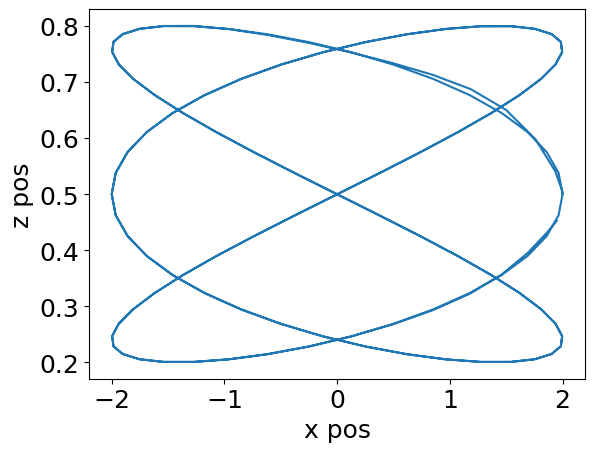

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_sim['x'], x_sim['z'])

ax.set_xlabel('x pos')
ax.set_ylabel('z pos')

# Simulate noisy measurements

Choose noise properties for each sensor, and apply the noise to each measurement stream

In [42]:
measurement_noise_stds = {'optic_flow': 1,
                          'theta': 0.1, 
                          'theta_dot': 0.1,
                          'accel_x': 0.2, 
                          'accel_z': 0.2,
                          #'k': 0.1,
                         }

In [9]:
measurement_noise_stds = {'optic_flow': 1,
                          'theta_dot': 0.1, 
                          'k': 0.1,
                         }

In [8]:
measurement_noise_stds = {'optic_flow': 1,
                          'theta_dot': 0.1,
                          'accel_x': 0.2, 
                          'accel_z': 0.2,
                          #'k': 0.1,
                         }

In [10]:
y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key])) for key in y_sim.keys()}

<Axes: xlabel='Time', ylabel='optic_flow'>

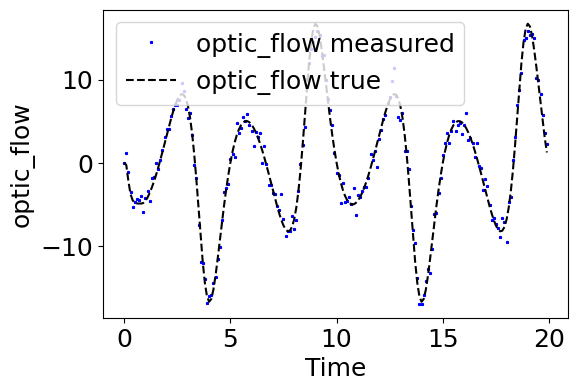

In [11]:
plot_tme(t_sim, y_sim['optic_flow'], y_noisy['optic_flow'], label_var='optic_flow')

In [12]:
#plot_tme(t_sim, y_sim['accel_x'], y_noisy['accel_x'], label_var='accel_x')

### Save data as dataframes

In [13]:
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

# Kalman filter parameters and initilization

In [14]:
x0 = np.ones(7)*2
u0 = np.zeros(2)
P0 = np.eye(7)*1

In [15]:
R = np.diag( list(measurement_noise_stds.values()) )**2
Q = np.diag([1e-4]*len(x0))

In [16]:
dt = np.mean(np.diff(t_sim))

# Extended Kalman Filter

In [17]:
EKF = extended_kalman_filter.EKF(f, h, x0, u0, P0, Q, R,
                                 dynamics_type='continuous', discretization_timestep=dt,
                                 circular_measurements=(1,0,0,0,0,0,0))

In [18]:
EKF.estimate(y_noisy_df, u_sim_df)

In [19]:
EKF.history.keys()

dict_keys(['X', 'U', 'Z', 'P', 'P_diags', 'R', 'Q', 'F', 'H', 'S', 'K', 'E', 'rho', 'Jk', 'inv_Jk'])

In [20]:
# State estimate
x_est = pd.DataFrame(np.vstack(EKF.history['X']), columns=f(None,None,return_state_names=True))

In [21]:
# Covariance diagonals
P_diags = np.vstack([np.diag(EKF.history['P'][i]) for i in range(len(EKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=f(None,None,return_state_names=True))

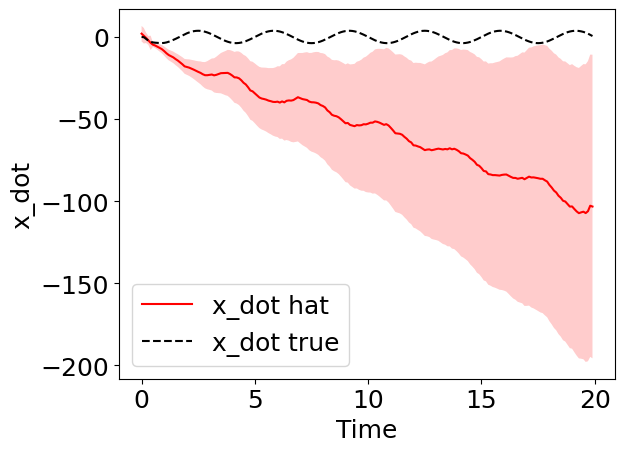

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'x_dot'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

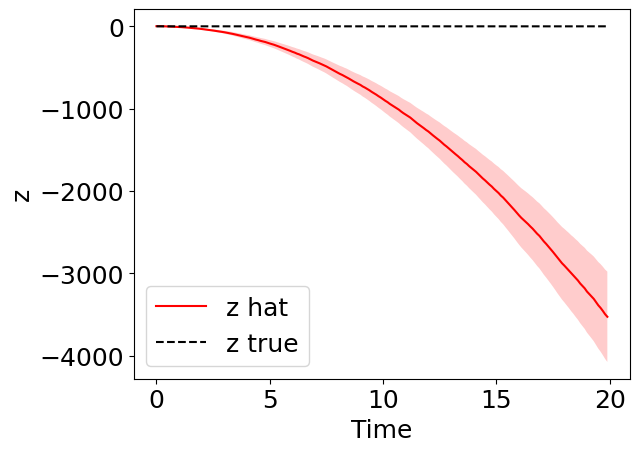

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'z'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

# Unscented Kalman Filter

In [24]:
UKF = unscented_kalman_filter.UKF(f, h, x0, u0, P0, Q, R,
                                 dynamics_type='continuous', discretization_timestep=dt,
                                 alpha=0.1)

In [25]:
UKF.estimate(y_noisy_df, u_sim_df)

In [26]:
UKF.history.keys()

dict_keys(['X', 'P', 'P_diags', 'sigma_points'])

In [27]:
# State estimate
x_est = pd.DataFrame(np.vstack(UKF.history['X']), columns=f(None,None,return_state_names=True))

In [28]:
# Covariance diagonals
P_diags = np.vstack([np.diag(UKF.history['P'][i]) for i in range(len(UKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=f(None,None,return_state_names=True))

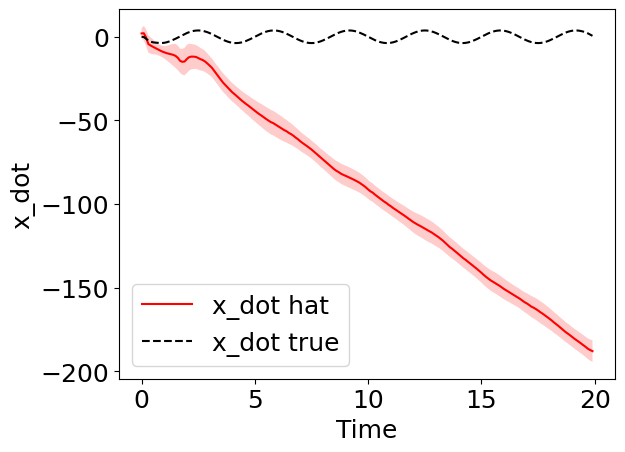

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'x_dot'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

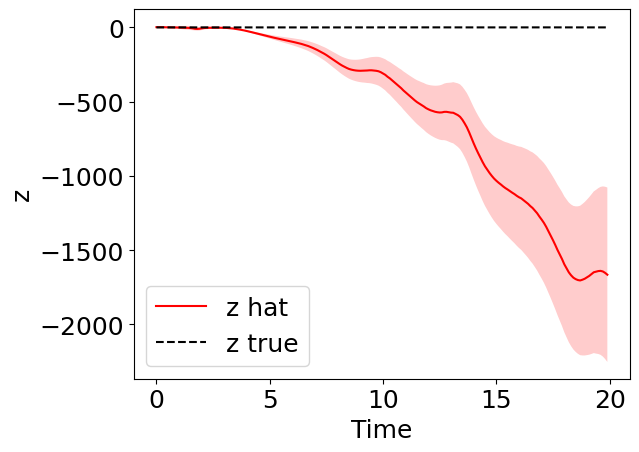

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'z'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)